In [459]:
%load_ext autoreload
%autoreload 2
from oogeso import multicarrier
from oogeso import plots
import matplotlib.pyplot as plt
import IPython
import pyomo.environ as pyo
import logging
import pandas as pd
plots.plotter='plotly'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Notes
Why infeasible at t=16 (just as G2 is supposed to start up


In [463]:
datafile = "data_test2.xlsx"
data,profiles = multicarrier.read_data_from_xlsx(datafile)

for dev in ['GT1','GT2']:
    data['paramDeviceOnTimestepsInitially'][dev] = 10
    data['paramDeviceIsOnInitially'][dev] = 1

#data['paramParameters']['elDispatchMargin']=0 # this has no effect

# problem: infeasible when second GT is needed - i.e. fail to start up in time. (still in prep when needed?)

In [464]:
mc = multicarrier.Multicarrier(loglevel="INFO")
mc.createModelInstance(data,profiles)

2020-11-04 13:50:23 INFO: TODO: objective function definition
2020-11-04 13:50:23 INFO: TODO: separator power (eta) and heat (eta2) demand
2020-11-04 13:50:23 INFO: TODO: gas turbine power vs heat output
2020-11-04 13:50:23 INFO: TODO: startup cost
2020-11-04 13:50:23 INFO: TODO: el source: dieselgen, fuel, on-off variables
2020-11-04 13:50:23 INFO: TODO: liquid pump approximation ok?
2020-11-04 13:50:23 INFO: TODO: startup delay does not work with Pmin>0
2020-11-04 13:50:23 INFO:       -use of prevHasBeenOn does not work as intended
2020-11-04 13:50:23 INFO: TODO: flow vs pressure equations for liquid flows
2020-11-04 13:50:23 INFO: TODO: pressure deviation limits per node
2020-11-04 13:50:23 INFO: TODO: Update Pmin constraint to allow GT startup delay
2020-11-04 13:50:24 INFO: Valid elReserveMargin not defined -> no constraint


In [465]:
status = mc.solveMany(solver="cbc",timerange=[0,90],write_yaml=False)

2020-11-04 13:50:24 INFO: Solving timestep=0
2020-11-04 13:50:24 INFO: Solving timestep=4
2020-11-04 13:50:25 INFO: Solving timestep=8
2020-11-04 13:50:25 INFO: Solving timestep=12
2020-11-04 13:50:25 INFO: Solving timestep=16
2020-11-04 13:50:26 INFO: Solving timestep=20
2020-11-04 13:50:26 INFO: Solving timestep=24
2020-11-04 13:50:26 INFO: Solving timestep=28
2020-11-04 13:50:27 INFO: Solving timestep=32
2020-11-04 13:50:27 INFO: Solving timestep=36
2020-11-04 13:50:27 INFO: Solving timestep=40
2020-11-04 13:50:27 INFO: Solving timestep=44
2020-11-04 13:50:28 INFO: Solving timestep=48
2020-11-04 13:50:28 INFO: Solving timestep=52
2020-11-04 13:50:28 INFO: Solving timestep=56
2020-11-04 13:50:28 INFO: Solving timestep=60
2020-11-04 13:50:29 INFO: Solving timestep=64
2020-11-04 13:50:29 INFO: Solving timestep=68
2020-11-04 13:50:29 INFO: Solving timestep=72
2020-11-04 13:50:30 INFO: Solving timestep=76
2020-11-04 13:50:30 INFO: Solving timestep=80
2020-11-04 13:50:31 INFO: Solving tim

In [466]:
#mc.instance.constrDevice_startup_delay._data['GT2',0].pprint()
#mc.instance.constrDevice_startup_delay.clear()
#mc.instance.constrDevice_startup_delay.construct()
#mc.instance.constrDevice_startup_delay._data
#mc.instance.constrDevice_startup_delay.reconstruct()
mc.instance.constrTerminalEnergyBalance['el','node1','out',0].pprint()
mc.instance.constrTerminalEnergyBalance['el','node1','in',0].pprint()
#mc.instance.constrDevice_gasturbine.pprint()
mc.instance.constrDevice_ramprate['GT2',1].pprint()

#mc.instance.pprint()

{Member of constrTerminalEnergyBalance} : Size=480, Index=constrTerminalEnergyBalance_index, Active=True
    Key                       : Lower : Body                                                                                                                                         : Upper : Active
    ('el', 'node1', 'out', 0) :   0.0 : - varDeviceFlow[GT1,el,out,0] - varDeviceFlow[GT2,el,out,0] - varDeviceFlow[GT3,el,out,0] - varTerminalFlow[node1,el,0] + varEdgeFlow[el1,0] :   0.0 :   True
{Member of constrTerminalEnergyBalance} : Size=480, Index=constrTerminalEnergyBalance_index, Active=True
    Key                      : Lower : Body                                               : Upper : Active
    ('el', 'node1', 'in', 0) :   0.0 : - varTerminalFlow[node1,el,0] + varEdgeFlow[el2,0] :   0.0 :   True
{Member of constrDevice_ramprate} : Size=24, Index=constrDevice_ramprate_index, Active=True
    Key        : Lower  : Body                                                      : Up

In [467]:
gt='GT2'
print(pyo.value(mc.instance.paramDeviceIsOnInitially[gt]))
print(pyo.value(mc.instance.paramDevicePrepTimestepsInitially[gt]))
for t in range(6):
    cstr=mc.instance.constrDevice_startup_shutdown[gt,t]
    print(t,cstr.body,"=",cstr.upper)
for t in range(6):
    cstr=mc.instance.constrDevice_startup_delay[gt,t]
    print(t,cstr.body,"=",cstr.upper)
for t in range(6):
    cstr=mc.instance.constrDevicePmax[gt,t]
    print(t,cstr.body,"=",cstr.upper)
#mc._dfDeviceIsOn1

0.0
0
0 varDeviceIsOn[GT2,0] - paramDeviceIsOnInitially[GT2] + varDeviceStopping[GT2,0] = 0.0
1 varDeviceIsOn[GT2,1] - varDeviceIsOn[GT2,0] + varDeviceStopping[GT2,1] = 0.0
2 varDeviceIsOn[GT2,2] - varDeviceIsOn[GT2,1] + varDeviceStopping[GT2,2] = 0.0
3 varDeviceIsOn[GT2,3] - varDeviceIsOn[GT2,2] - (varDeviceStarting[GT2,0] - varDeviceStopping[GT2,3]) = 0.0
4 varDeviceIsOn[GT2,4] - varDeviceIsOn[GT2,3] - (varDeviceStarting[GT2,1] - varDeviceStopping[GT2,4]) = 0.0
5 varDeviceIsOn[GT2,5] - varDeviceIsOn[GT2,4] - (varDeviceStarting[GT2,2] - varDeviceStopping[GT2,5]) = 0.0
0 varDeviceIsPrep[GT2,0] = 0.0
1 varDeviceIsPrep[GT2,1] - varDeviceStarting[GT2,1] = 0.0
2 varDeviceIsPrep[GT2,2] - (varDeviceStarting[GT2,2] + varDeviceStarting[GT2,1]) = 0.0
3 varDeviceIsPrep[GT2,3] - (varDeviceStarting[GT2,3] + varDeviceStarting[GT2,2] + varDeviceStarting[GT2,1]) = 0.0
4 varDeviceIsPrep[GT2,4] - (varDeviceStarting[GT2,4] + varDeviceStarting[GT2,3] + varDeviceStarting[GT2,2]) = 0.0
5 varDeviceIsPrep[GT

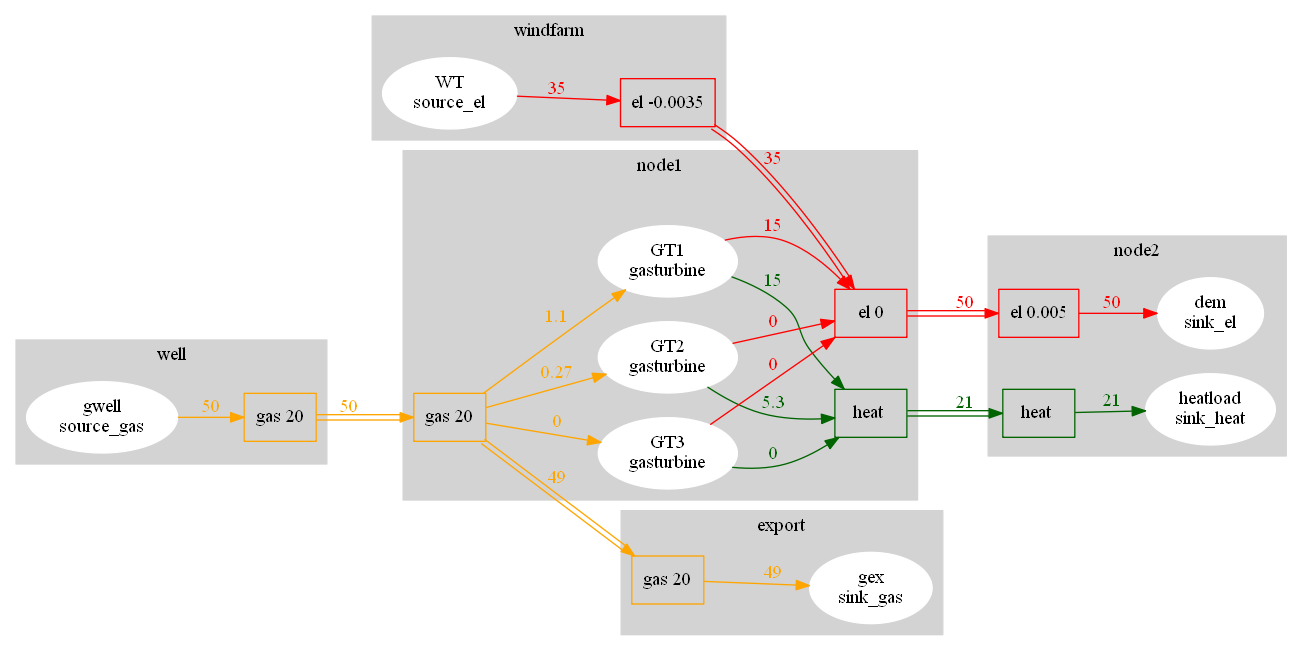

In [468]:
dotG=plots.plotNetwork(mc,timestep=15,filename=None)
#IPython.display.SVG(dotG.create_svg()) #original size, vector graphics
IPython.display.Image(dotG.create_png()) #scales automatically to page width

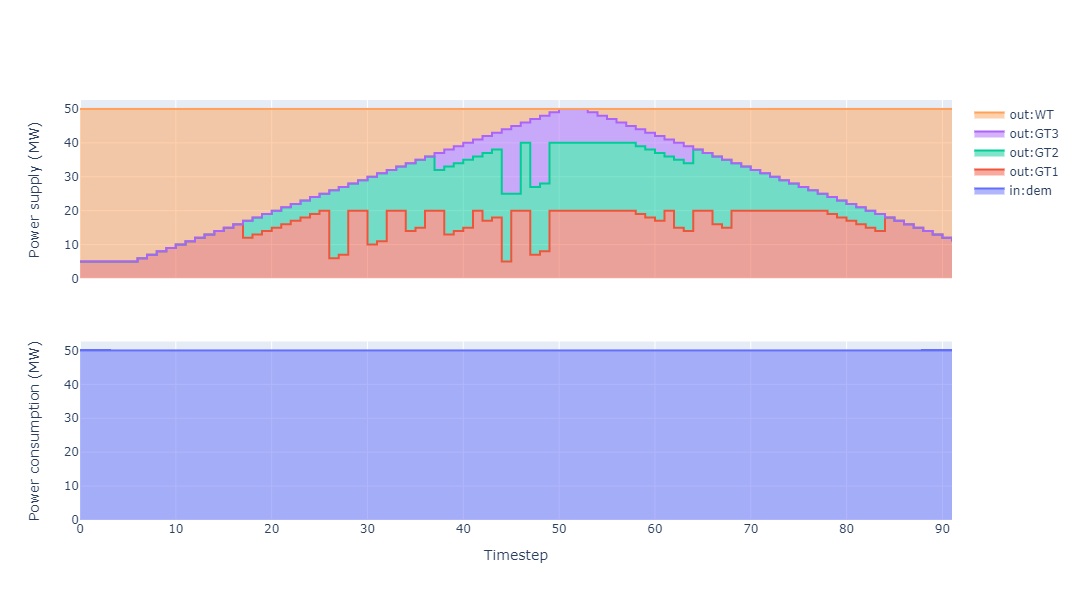

In [469]:
fig=plots.plot_SumPowerMix(mc,carrier="el")

In [443]:
# Problem = isOn = isPrep, isStarting=0
gt='GT2'
dfStart=pd.concat([
    mc._dfDeviceStarting[gt],
    mc._dfDeviceIsPrep[gt],
    mc._dfDeviceIsOn[gt],
    mc._dfDeviceStopping[gt]],axis=1)
dfStart.columns=['starting','prep','on','stopping']
dfStart

,starting,prep,on,stopping
time,,,,
0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0


In [431]:
#mc.instance.varDeviceIsPrep.pprint()

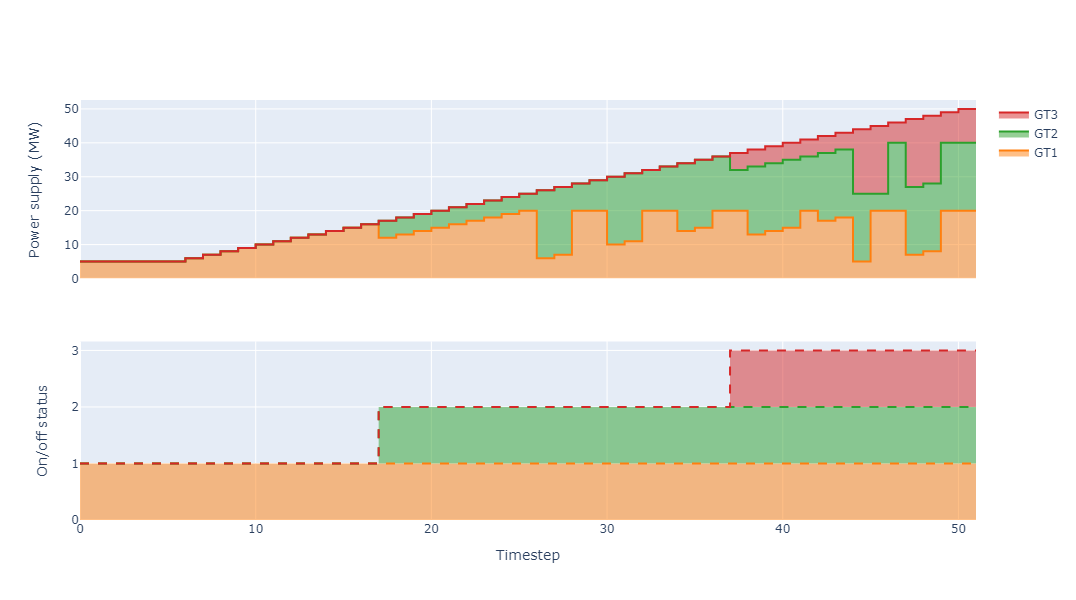

In [432]:
plots.plot_deviceprofile(mc,devs=['GT1','GT2','GT3'],includeOnOff=True)

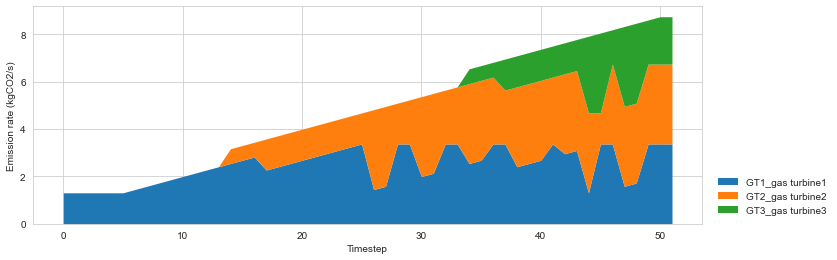

In [433]:
#plots.plot_CO2rate(mc)
plots.plot_CO2rate_per_dev(mc)

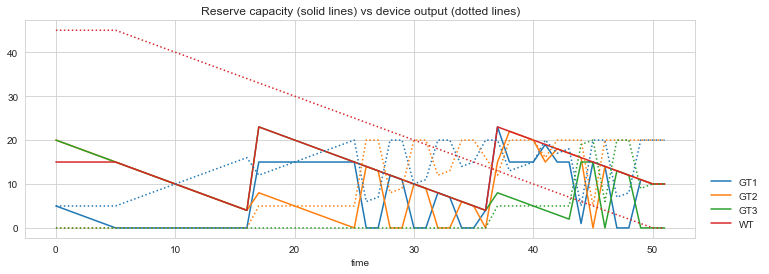

In [434]:
plots.plotElReserve(mc)